## FDW Crop Production Data Analysis - Kenya

In [1]:
import os, sys, glob, json
from itertools import product, compress, chain
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from tools import save_hdf, save_npz, load_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_GrainTypeAgg, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear
from tools_graphic import PlotBarProduction, PlotLinePAY, PlotHeatCropSystem, PlotHeatSeasonData
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [43]:
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'KE', 'Kenya'
df = pd.read_hdf('./data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
# long
data_fdw = df[
    (df['season_name'] == 'Long') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
data_fdw['year'] = data_fdw['growing_year']
data_fdw_long = data_fdw.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('Maize')
# short
data_fdw = df[
    (df['season_name'] == 'Short') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
data_fdw['year'] = data_fdw['harvest_year']
data_fdw_short = data_fdw.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('Maize')
# data_fdw_short.index = data_fdw_short.index - 1
# Annual
data_fdw = df[
    (df['season_name'] == 'Annual') &
    (df['product'].isin(['Maize'])) &
    (df['indicator'] == 'production')
]
data_fdw['year'] = data_fdw['harvest_year']
data_fdw_annual = data_fdw.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('Maize')
data_fdw = pd.concat([data_fdw_long, data_fdw_short, data_fdw_annual],axis=1).sum(1)
# data_fdw.index = data_fdw.index - 1
# ---------------------------------------------------- #

In [44]:
# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('./data/crop/adm_fao_stat.csv', index_col=0)
data_fao1 = df[
    (df['cnt_name'] == 'Kenya') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# data_fao1.index = data_fao1.index - 1
# ---------------------------------------------------- #

# Load FAO-AgroMaps Subnational Production Data ------ #
df = pd.read_csv('./data/crop/adm_fao_agromaps.csv', index_col=0, low_memory=False)
data_fao2 = df[
    (df['cnt_name'] == 'Kenya') &
    (df['cpc2_name'] == 'Maize (corn)') &
    (df['adm_level'] == 2) &
    (df['indicator'] == 'Production')
].pivot_table(index='year',columns='admx_code',values='value')
# print(data_fao2)
# data_fao2.index = data_fao2.index - 1
data_fao2 = data_fao2.sum(1)
# ---------------------------------------------------- #

# Merge all data ------------------------------------- #
data = pd.concat([data_fdw,data_fao1,data_fao2], axis=1, keys=['FDW','FAO_STAT','FAO_AMAP']).sort_index()
# ---------------------------------------------------- #
data.tail()

,FDW,FAO_STAT,FAO_AMAP
year,,,
2016,3004152.75,3339000.0,NaN
2017,NaN,3186000.0,NaN
2018,NaN,4013777.0,NaN
2019,3652419.15,3582000.0,NaN
2020,NaN,3789000.0,NaN


In [45]:
# Load precipitation
prcp = pd.read_hdf('./data/adm.prcp.chirps-v2.crop.hdf')[fnids]
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=4)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == 3]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = 'MAM PRCP (mm)'
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'Correlation:\n{corr_value}')

Correlation:
               FDW  FAO_STAT  FAO_AMAP      PRCP
FDW       1.000000  0.864250       NaN  0.362366
FAO_STAT  0.864250  1.000000       NaN  0.499301
FAO_AMAP       NaN       NaN       NaN       NaN
PRCP      0.362366  0.499301       NaN  1.000000


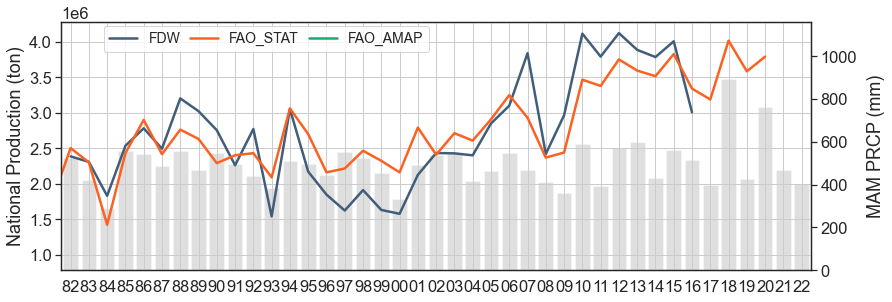

In [49]:
years = np.arange(1982,2023)
sns.set(style="white", font_scale=1.5)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker=None, color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()